In [150]:
# https://huggingface.co/HYPJUDY/layoutlmv3-base-finetuned-publaynet/discussions/3#6420675036e47752c3114631

! git lfs install
! git clone https://huggingface.co/HYPJUDY/layoutlmv3-base-finetuned-publaynet
! mv layoutlmv3-base-finetuned-publaynet/model_final.pth layoutlmv3-base-finetuned-publaynet/pytorch_model.bin

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Updated Git hooks.
Git LFS initialized.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
fatal: destination path 'layoutlmv3-base-finetuned-publaynet' already exists and is not an empty directory.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `t

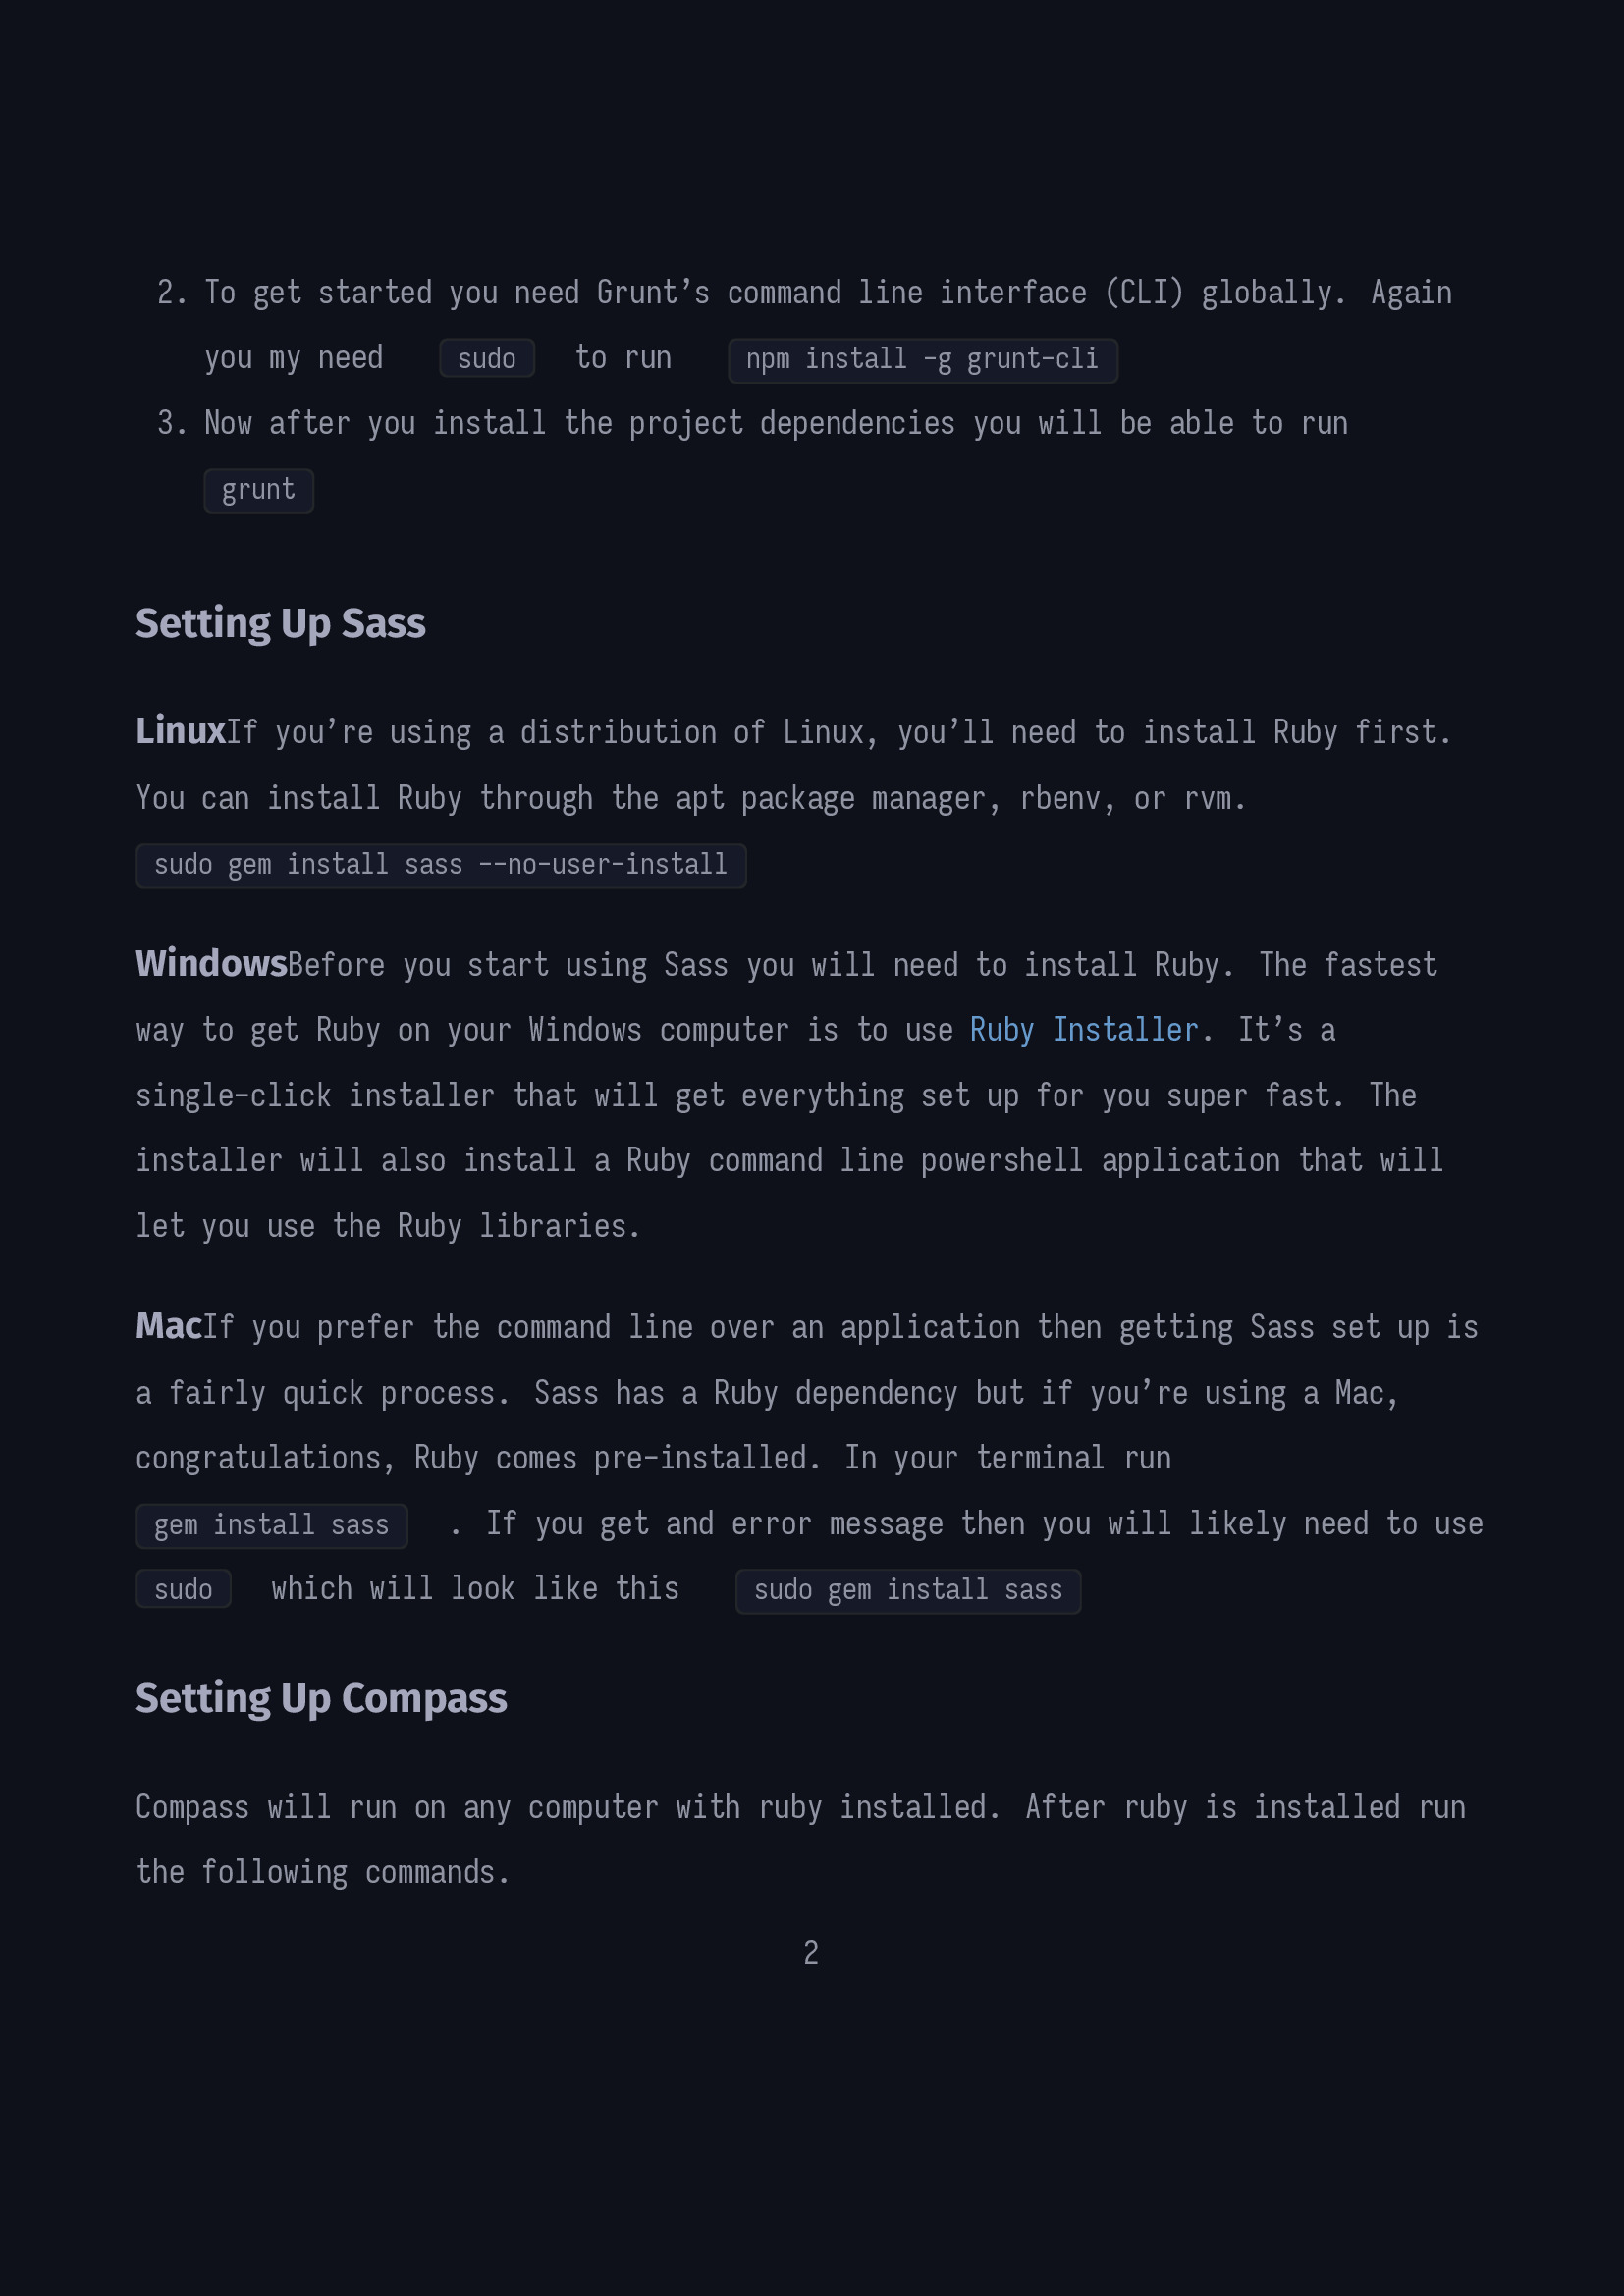

In [151]:
from PIL import Image

img = Image.open("./test.jpg")
img

In [152]:
import pytesseract as ts
import pandas as pd

# pytesseract:
# https://mpolinowski.github.io/docs/IoT-and-Machine-Learning/ML/2021-10-31--tesseract_ocr_arch_linux/2021-10-31/

data = ts.image_to_data(img)
data_list = list(map(lambda x: x.split('\t'), data.split('\n')))

df = pd.DataFrame(data_list[1:], columns=data_list[0])

df.dropna(inplace=True) # Drop empty values and rows
col_int = ['level','page_num','block_num','par_num','line_num','word_num','left','top','width','height']
df[col_int] = df[col_int].astype(int) # Change all columns with number values to type int
df['conf'] = df['conf'].astype(float)

df.head(10)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1654,2339,-1.000000,
1,2,1,1,0,0,0,162,281,1316,168,-1.000000,
2,3,1,1,1,0,0,162,281,1316,168,-1.000000,
3,4,1,1,1,1,0,162,281,1316,35,-1.000000,
4,5,1,1,1,1,1,162,284,26,25,92.987366,2.
5,5,1,1,1,1,2,210,284,29,25,91.972969,To
6,5,1,1,1,1,3,259,284,48,32,92.866211,get
7,5,1,1,1,1,4,326,284,113,25,91.863068,started
8,5,1,1,1,1,5,459,291,47,25,91.363182,you
9,5,1,1,1,1,6,526,284,63,25,90.710197,need


In [155]:
from transformers import AutoProcessor, AutoModelForTokenClassification

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)  # As we are already doing OCR with tesseract
model = AutoModelForTokenClassification.from_pretrained("./layoutlmv3-base-finetuned-publaynet", num_labels=5)

image = img
words = df['text'].values.tolist()

def normalize_box(box):
    """Make the box coordinates between 0-1000"""
    max_dim = max(img.width, img.height)
    return tuple(int(coord / max_dim * 1000) for coord in box)

boxes = list(zip(
    df['left'], # left
    df['top'],  # top
    df['left'] + df['width'], # right
    df['top'] + df['height']  # bottom
))
boxes = [normalize_box(box) for box in boxes]
boxes

Some weights of the model checkpoint at ./layoutlmv3-base-finetuned-publaynet were not used when initializing LayoutLMv3ForTokenClassification: ['trainer', 'iteration', 'model']
- This IS expected if you are initializing LayoutLMv3ForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMv3ForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at ./layoutlmv3-base-finetuned-publaynet and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[(0, 0, 707, 1000),
 (69, 120, 631, 191),
 (69, 120, 631, 191),
 (69, 120, 631, 135),
 (69, 121, 80, 132),
 (89, 121, 102, 132),
 (110, 121, 131, 135),
 (139, 121, 187, 132),
 (196, 124, 216, 135),
 (224, 121, 251, 132),
 (260, 120, 308, 132),
 (317, 121, 365, 132),
 (374, 121, 401, 132),
 (410, 121, 472, 132),
 (482, 120, 514, 134),
 (523, 121, 584, 135),
 (597, 121, 631, 135),
 (89, 149, 477, 163),
 (89, 152, 109, 163),
 (117, 152, 130, 163),
 (139, 149, 166, 160),
 (200, 150, 224, 160),
 (250, 149, 263, 160),
 (273, 152, 292, 160),
 (325, 153, 343, 163),
 (351, 150, 394, 160),
 (402, 153, 414, 163),
 (421, 150, 477, 163),
 (69, 178, 586, 191),
 (69, 178, 80, 188),
 (89, 178, 109, 188),
 (117, 178, 152, 188),
 (160, 181, 180, 191),
 (189, 178, 237, 188),
 (246, 178, 266, 188),
 (274, 178, 323, 191),
 (331, 178, 415, 191),
 (424, 181, 444, 191),
 (452, 178, 479, 188),
 (488, 178, 501, 188),
 (510, 178, 536, 188),
 (545, 178, 558, 188),
 (567, 181, 586, 188),
 (97, 207, 128, 220),
 (97

In [156]:
encoding = processor(image, words, boxes=boxes, return_tensors='pt')
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([1, 277])
attention_mask torch.Size([1, 277])
bbox torch.Size([1, 277, 4])
pixel_values torch.Size([1, 3, 224, 224])


In [157]:
import torch

with torch.no_grad():
    outputs = model(**encoding)

logits = outputs.logits

predicted_labels = logits.argmax(dim=-1).squeeze().tolist()

token_boxes = encoding.bbox.squeeze().tolist()
predicted_output = list(zip(token_boxes, predicted_labels))
predicted_output


/home/rutayisire/projects/dataset-retriever/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


[([0, 0, 0, 0], 0),
 ([69, 121, 80, 132], 0),
 ([69, 121, 80, 132], 0),
 ([89, 121, 102, 132], 0),
 ([110, 121, 131, 135], 0),
 ([139, 121, 187, 132], 0),
 ([196, 124, 216, 135], 1),
 ([224, 121, 251, 132], 0),
 ([260, 120, 308, 132], 0),
 ([260, 120, 308, 132], 0),
 ([260, 120, 308, 132], 0),
 ([260, 120, 308, 132], 0),
 ([260, 120, 308, 132], 0),
 ([317, 121, 365, 132], 0),
 ([374, 121, 401, 132], 0),
 ([410, 121, 472, 132], 0),
 ([482, 120, 514, 134], 0),
 ([482, 120, 514, 134], 3),
 ([482, 120, 514, 134], 3),
 ([482, 120, 514, 134], 4),
 ([523, 121, 584, 135], 0),
 ([523, 121, 584, 135], 0),
 ([597, 121, 631, 135], 0),
 ([89, 152, 109, 163], 0),
 ([117, 152, 130, 163], 0),
 ([139, 149, 166, 160], 4),
 ([200, 150, 224, 160], 4),
 ([250, 149, 263, 160], 0),
 ([273, 152, 292, 160], 0),
 ([325, 153, 343, 163], 0),
 ([351, 150, 394, 160], 0),
 ([402, 153, 414, 163], 0),
 ([402, 153, 414, 163], 0),
 ([421, 150, 477, 163], 1),
 ([421, 150, 477, 163], 3),
 ([421, 150, 477, 163], 0),
 ([69,

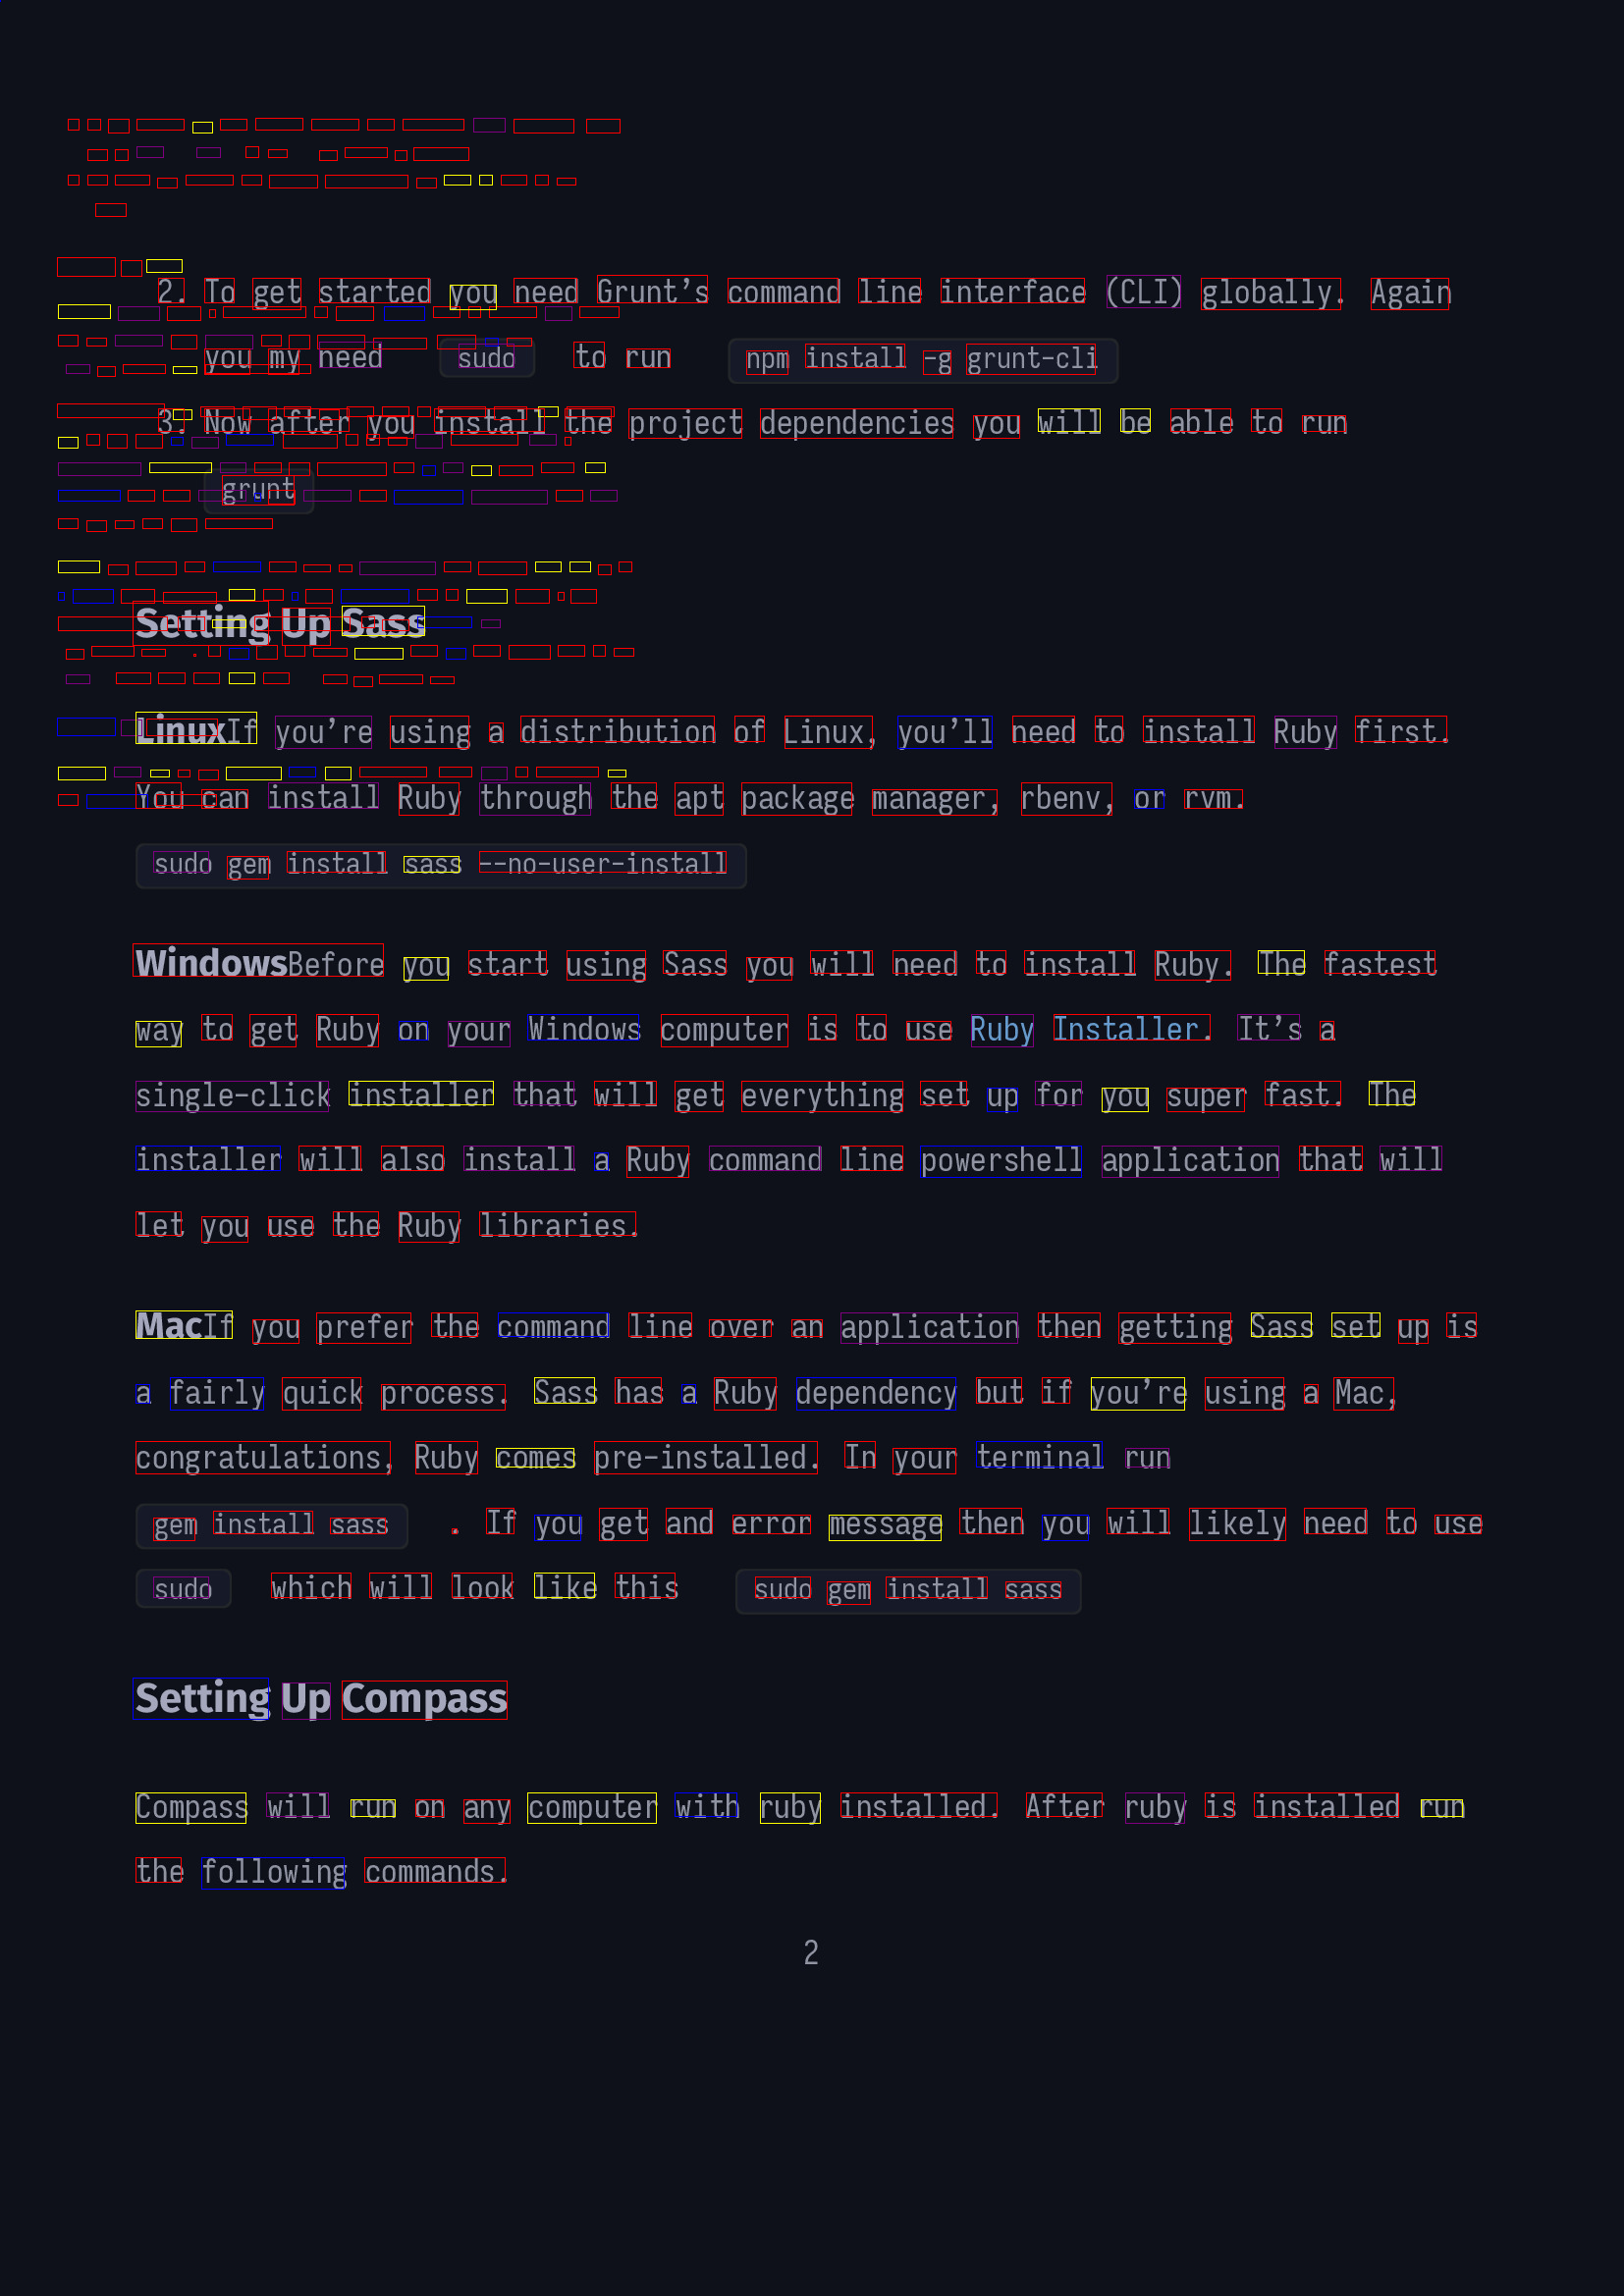

In [162]:
from PIL import ImageDraw, ImageFont

def unnormalize_box(box):
    max_dim = max(img.width, img.height)
    return tuple(int(coord / 1000 * max_dim) for coord in box)

annotated_img = img.copy()
draw = ImageDraw.Draw(annotated_img)

font = ImageFont.load_default()

colors = ['red', 'yellow', 'green', 'blue', 'purple']

for box, predicted_label in predicted_output:
    draw.rectangle(unnormalize_box(box), outline=colors[predicted_label])
    
annotated_img